In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import pandas as pd
import os

In [2]:
ecg =[]
bp_min = []
bp_max = []
sample_size  = 64
for i in range(4):
    data = scipy.io.loadmat(f"data/part_{i+1}.mat")['p']
    for i in range(1000):
        temp_mat = data[0 , i]
        temp_length = temp_mat.shape[1]
        for j in range((int)(temp_length/sample_size)):
            temp_ecg = temp_mat[2, j*sample_size:(j+1)*sample_size]
            print(temp_ecg)
            break 
            temp_bp = temp_mat[1, j*sample_size:(j+1)*sample_size]
            ecg.append(temp_ecg)
            bp_min.append(np.min(temp_bp))
            bp_max.append(np.max(temp_bp))
        break
    break

[-0.06060606 -0.07526882 -0.07038123 -0.03519062  0.02443793  0.08993157
  0.15493646  0.20478983  0.24975562  0.27468231  0.29472141  0.30498534
  0.30987292  0.31964809  0.31964809  0.32502444  0.32502444  0.32502444
  0.32502444  0.31964809  0.31964809  0.32991202  0.35483871  0.36999022
  0.39002933  0.42473118  0.45014663  0.4599218   0.42473118  0.3597263
  0.28983382  0.25464321  0.24975562  0.24975562  0.23998045  0.24486804
  0.42473118  0.99022483  1.4457478   1.07038123  0.3797654   0.09481916
  0.07478006  0.09970674  0.11485826  0.12463343  0.12952102  0.13978495
  0.14467253  0.14956012  0.15493646  0.16471163  0.16471163  0.16471163
  0.15982405  0.15493646  0.14467253  0.12463343  0.09481916  0.05962854
  0.01466276 -0.03030303 -0.06549365 -0.09042033]


In [4]:
res = pd.DataFrame({"data": ecg , "blood_presure_min":bp_min , "blood_presure_max":bp_max})
res.head()

,data,blood_presure_min,blood_presure_max
0,"[-0.06060606060606061, -0.07526881720430108, -...",67.062955,124.601310
1,"[-0.09530791788856305, -0.07038123167155426, -...",66.525670,123.038299
2,"[-0.10019550342130987, -0.045454545454545456, ...",65.597632,120.986846
3,"[0.024437927663734114, 0.06989247311827956, 0....",66.134917,118.349265
4,"[0.28005865102639294, 0.30009775171065495, 0.3...",66.134917,121.621820


In [5]:
res.dtypes

data                  object
blood_presure_min    float64
blood_presure_max    float64
dtype: object

In [6]:
res.describe(include=['number']).round().astype(int)

,blood_presure_min,blood_presure_max
count,1770902,1770902
mean,67,126
std,12,25
min,50,54
25%,59,106
50%,65,124
75%,73,144
max,192,200


In [7]:
res.shape

(1770902, 3)

In [8]:
res = res.sample(1000000)

In [9]:
min_blood_mask = res['blood_presure_min'].between(50, 120, inclusive="both")
max_blood_mask = res['blood_presure_max'].between(60, 200, inclusive='left')
mask = np.logical_and(min_blood_mask , max_blood_mask)
mask.sum()

996779

In [10]:
df = res[mask]
print(df.shape)

(996779, 3)


In [11]:
#build model/

def conv_block(x , num_filters):
    x = tf.keras.layers.Conv1D(num_filters , kernel_size=3 , strides=1 ,padding="same",kernel_regularizer=tf.keras.regularizers.l1_l2())(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x 

In [13]:
class HyperLoss(tf.keras.losses.Loss):
    def __init__(self , threshold=5,**kwargs):
        self.threshold = threshold
        super(HyperLoss ,self).__init__(**kwargs)
    def call(self, y_true ,  y_pred):
        error = y_true - y_pred
        is_samll = tf.abs(error)<self.threshold
        square_loss = tf.square(error)/2.0
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2.0
        return tf.where(is_samll , square_loss , linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold":self.threshold}



In [17]:
new_model = tf.keras.models.load_model("ecg_model2",custom_objects={"HyperLoss":HyperLoss()})

In [ ]:
def res_block(x , filters, shortcut_filter):
    y = x 
    for i in filters:
        x = conv_block(x, i)
    y = tf.keras.layers.Conv1D(shortcut_filter,kernel_size=1 ,padding='same')(y)
    y = tf.keras.layers.ReLU()(y)
    y = tf.keras.layers.BatchNormalization()(y)
    res = tf.keras.layers.Add()([x, y])
    return res

In [ ]:
def sequence_unit(x ,n_units):
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units , activation="tanh",return_sequences=True))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x 

In [ ]:
def build_model():
    input_ = tf.keras.layers.Input(shape=(sample_size,1))
    input_ = tf.keras.layers.BatchNormalization()(input_)
    y = sequence_unit(input_ , 64)
    y = tf.keras.layers.Dropout(0.5)(y)
    y = sequence_unit(y , 128)
    y = tf.keras.layers.Conv1D(256 ,kernel_size=1 , padding='same', activation="relu")(y)
    x = tf.keras.layers.Conv1D(filters=16 , kernel_size=3 , padding='same')(input_)
    x = res_block(x, [16, 16 , 32], 32)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x , [32, 64, 64] , 64)
    x = res_block(x , [64 , 128, 128] , 128)
    x = res_block(x , [128] , 128)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Concatenate()([x,y])
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(64 , activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    out1 = tf.keras.layers.Dense(1 , activation="relu",name ="min")(x)
    out2 = tf.keras.layers.Dense(1 , activation="relu",name ="max")(x)
    model = tf.keras.models.Model(inputs=[input_], outputs={"min":out1 , "max":out2})
    return model
    


In [ ]:
model = build_model()
model.summary()

In [19]:
#get data 
ecgset = np.array(df['data'].to_list())
ecgset.shape

(996779, 64)

In [20]:
bp_min_set = np.array(df['blood_presure_min']).reshape(-1,1)
bp_min_set.shape

(996779, 1)

In [21]:
bp_max_set = np.array(df['blood_presure_max']).reshape(-1,1)
bp_max_set.shape

(996779, 1)

In [ ]:
class HyperLoss(tf.keras.losses.Loss):
    def __init__(self , threshold=5,**kwargs):
        self.threshold = threshold
        super(HyperLoss ,self).__init__(**kwargs)
    def call(self, y_true ,  y_pred):
        error = y_true - y_pred
        is_samll = tf.abs(error)<self.threshold
        square_loss = tf.square(error)/2.0
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2.0
        return tf.where(is_samll , square_loss , linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold":self.threshold}



In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(1e-3), loss=HyperLoss(), metrics=['mse','mae'])

In [ ]:
data_points = 300000

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode = "min") ,
               tf.keras.callbacks.ModelCheckpoint("ecg_model", monitor="val_loss", save_best_only=True)]

In [22]:
test = np.expand_dims(ecgset[0].reshape(64,1) , 0)
new_model(test)

{'min': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[58.90689]], dtype=float32)>,
 'max': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[97.18229]], dtype=float32)>}

In [24]:
ecgset_prep = ecgset.reshape(-1, 64 ,1)
ecgset_prep.shape

(996779, 64, 1)

In [ ]:
model(ecgset_prep[:3])

In [ ]:
bp_max_set.shape

In [ ]:
data_points*0.01

In [84]:
try :
    history = model.fit(ecgset_prep[:data_points] , y={"min":bp_min_set[:data_points] , "max":bp_max_set[:data_points]}, 
                    batch_size=64,epochs=20 ,
                    callbacks=callbacks , 
                    validation_split=0.01
           )
except KeyboardInterrupt :
    print("\nmodel is stoped ")


4641/4641 [==============================] - 10599s 2s/step - loss: 125.7342 - max_loss: 90.1674 - min_loss: 32.9896 - max_mse: 669.6264 - max_mae: 20.3966 - min_mse: 134.8081 - min_mae: 8.7809 - val_loss: 98.9437 - val_max_loss: 67.3273 - val_min_loss: 29.0242 - val_max_mse: 408.8259 - val_max_mae: 15.7896 - val_min_mse: 114.9258 - val_min_mae: 7.9468
Epoch 17/20
4641/4641 [==============================] - ETA: 0s - loss: 123.5234 - max_loss: 88.5565 - min_loss: 32.3802 - max_mse: 650.6627 - max_mae: 20.0737 - min_mse: 131.2875 - min_mae: 8.6518

INFO:tensorflow:Assets written to: ecg_model\assets


INFO:tensorflow:Assets written to: ecg_model\assets


4641/4641 [==============================] - 10943s 2s/step - loss: 123.5234 - max_loss: 88.5565 - min_loss: 32.3802 - max_mse: 650.6627 - max_mae: 20.0737 - min_mse: 131.2875 - min_mae: 8.6518 - val_loss: 97.9852 - val_max_loss: 67.1018 - val_min_loss: 28.2602 - val_max_mse: 410.4089 - val_max_mae: 15.7271 - val_min_mse: 111.2037 - val_min_mae: 7.7762
Epoch 18/20
2740/4641 [================>.............] - ETA: 1:22:32 - loss: 121.9739 - max_loss: 87.4941 - min_loss: 31.8452 - max_mse: 637.2076 - max_mae: 19.8595 - min_mse: 128.3233 - min_mae: 8.5437
model is stoped 


In [27]:
new_model(ecgset_prep[:3]) , bp_min_set[:3], bp_max_set[:3]

({'min': <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
  array([[58.90689],
         [67.18769],
         [73.33036]], dtype=float32)>,
  'max': <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
  array([[ 97.18229],
         [133.36284],
         [137.70827]], dtype=float32)>},
 array([[66.52560503],
        [52.34129101],
        [76.46680343]]),
 array([[136.86104647],
        [ 98.00071508],
        [116.75366151]]))

In [28]:
for layer in new_model.layers:
    layer.trainable=True

In [30]:
valid_ecg = ecgset_prep[sample_size:sample_size+1000]
valid_min = bp_min_set[sample_size:sample_size+1000]
valid_max = bp_max_set[sample_size:sample_size+1000]


In [31]:
predicted = new_model.predict(valid_ecg)

32/32 [==============================] - 5s 57ms/step


In [34]:
pred_min = predicted['min']
pred_max = predicted['max']

In [35]:
from sklearn.metrics import r2_score
min_ = r2_score(valid_min, pred_min)

In [36]:
max_ = r2_score(valid_max, pred_max)

In [37]:
min_ , max_

(-0.27242630741207297, -0.2712295123453585)

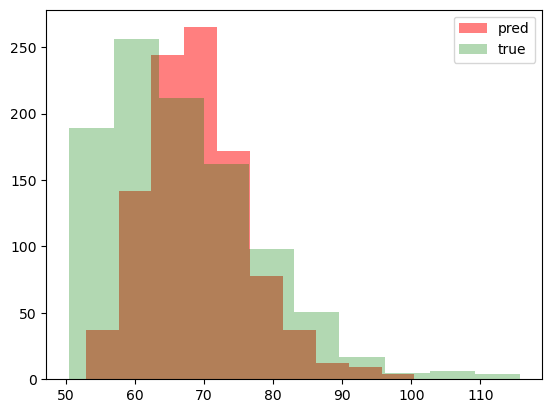

In [48]:
fig, ax = plt.subplots(1,1)
ax.hist(pred_min , label="pred",color="r",alpha=0.5)
ax.hist(valid_min , label="true",color="g",alpha=0.3)
ax.legend(['pred',"true"])

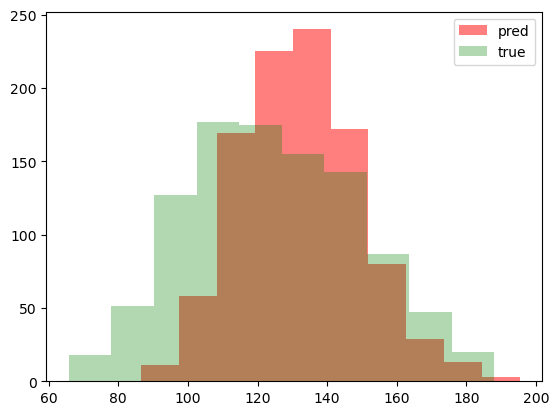

In [49]:
fig, ax = plt.subplots(1,1)
ax.hist(pred_max , label="pred",color="r",alpha=0.5)
ax.hist(valid_max , label="true",color="g",alpha=0.3)
ax.legend(['pred',"true"])

In [3]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
tf.config.list_physical_devices('GPU')

[]